# With TF

In [176]:
import keras
import tensorflow as tf
import numpy as np
from keras import layers
from keras.utils import image_dataset_from_directory
from keras.applications import vgg16
from keras.optimizers import Adam
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model
import matplotlib.pyplot as plt

In [177]:
def show_image(image_list, label_list= None):
    """Plot images."""
    
    fig = plt.figure(figsize=(10, 5))
    for i, file in enumerate(image_list):
        
        # if image is numpy array
        if isinstance(file, np.ndarray):
            img= file
        # if image is PIL image
        else:
            img = np.array(file)
        
        print('Image shape:', img.shape)
        ax = fig.add_subplot(2, int(len(image_list)/2), i+1)
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(img)
    
        if label_list is not None:
            ax.set_title(label_list[i])
    
    plt.tight_layout()
    plt.show()

## Load Dataset

In [178]:
train_path= 'dataset/dogs-vs-cat/train'
valid_path= 'dataset/dogs-vs-cat/valid'
test_path= 'dataset/dogs-vs-cat/test'
batch_size= 32

train_ds= image_dataset_from_directory(
    train_path,
    image_size= (224, 224),
    batch_size= 32, 
    shuffle= True,
    seed= 1,
)
val_ds= image_dataset_from_directory(
    valid_path,
    image_size= (224, 224),
    batch_size= 32, 
    shuffle= True,
    seed= 1,
)
test_ds= image_dataset_from_directory(
    test_path,
    image_size= (224, 224),
    batch_size= 32, 
    shuffle= True,
    seed= 1,
)

Found 202 files belonging to 2 classes.
Found 103 files belonging to 2 classes.
Found 451 files belonging to 2 classes.


## Preprocess

In [179]:
# preprocessing
preprocessing= keras.Sequential([
    layers.Rescaling(scale= 1./255.),
    layers.Normalization(),

])
train_ds= train_ds.map(lambda x, y: (preprocessing(x), y))
val_ds= val_ds.map(lambda x, y: (preprocessing(x), y))
test_ds= test_ds.map(lambda x, y: (preprocessing(x), y))

Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)


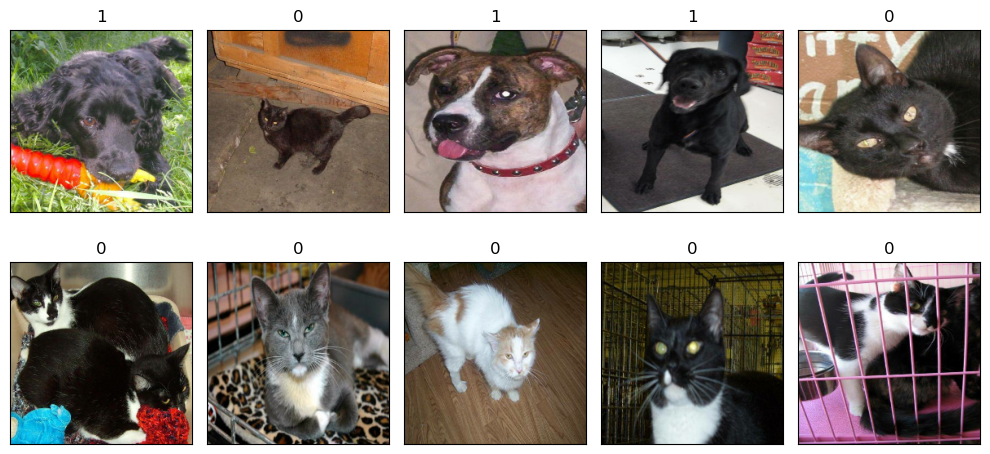

In [190]:
samples= train_ds.unbatch().take(10)
images= []
labels= []

for (image, label) in samples.as_numpy_iterator():
    images.append(image)
    labels.append(label)

show_image(images, labels)

## Create Model

In [86]:
base_model= vgg16.VGG16(include_top= False, 
                        weights= 'imagenet', 
                        input_shape= (224, 224, 3),
                        )
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [87]:
# freeze all layers
for layer in base_model.layers:
    layer.trainable= False

In [88]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [89]:
last_layer= base_model.get_layer(index= -1)
last_layer_output= last_layer.output
last_layer_output

<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

In [90]:
x= Flatten()(last_layer_output)
x= Dense(64, activation= 'relu', name= 'FC_2')(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(2, activation= 'softmax', name= 'softmax')(x)

new_model= Model(inputs= base_model.input, outputs= x)
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [91]:
new_model.compile(loss= 'binary_crossentropy', 
                  optimizer= Adam(learning_rate= 0.0001),
                  metrics= ['accuracy'])

In [92]:
epochs= 10
new_model.fit(train_ds, 
              steps_per_epoch= 4, 
              validation_data= val_ds, 
              validation_steps= 2, 
              epochs= epochs, 
              verbose= 1)

Epoch 1/10


ValueError: in user code:

    File "/home/anj/miniconda3/envs/deep-learning/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/home/anj/miniconda3/envs/deep-learning/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/anj/miniconda3/envs/deep-learning/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/home/anj/miniconda3/envs/deep-learning/lib/python3.10/site-packages/keras/engine/training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/anj/miniconda3/envs/deep-learning/lib/python3.10/site-packages/keras/engine/training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "/home/anj/miniconda3/envs/deep-learning/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/anj/miniconda3/envs/deep-learning/lib/python3.10/site-packages/keras/losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/anj/miniconda3/envs/deep-learning/lib/python3.10/site-packages/keras/losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/anj/miniconda3/envs/deep-learning/lib/python3.10/site-packages/keras/losses.py", line 2176, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/home/anj/miniconda3/envs/deep-learning/lib/python3.10/site-packages/keras/backend.py", line 5680, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 2) vs (None, 1)).


In [ ]:
test_loss, test_acc= new_model.evaluate(test_ds)
print(f'Test accuracy = {test_acc: .4f} - test loss = {test_loss: 4f}')

15/15 [==============================] - 55s 4s/step - loss: 0.2993 - accuracy: 0.9113
Test accuracy =  0.9113 - test loss =  0.299255


# With Pytorch

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets

from pathlib import Path
import os
from PIL import Image
import numpy as np

In [ ]:
dir_= Path('dataset/dogs-vs-cat/train')
train_set= datasets.ImageFolder(dir_)

dir_= Path('dataset/dogs-vs-cat/valid')
val_set= datasets.ImageFolder(dir_)

dir_= Path('dataset/dogs-vs-cat/test')
test_set= datasets.ImageFolder(dir_)